In [2]:
import gc
import itertools
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

import comet_ml
import tensorflow as tf
import torch
import torch.optim as optim
from load_data import load_data
from model import init_model
from rsl_depth_completion.conditional_diffusion.config import cfg as cfg_cls
from rsl_depth_completion.conditional_diffusion.custom_trainer import ImagenTrainer
from rsl_depth_completion.conditional_diffusion.train import train
from rsl_depth_completion.conditional_diffusion.utils import (
    dict2mdtable,
    log_params_to_exp,
)
from rsl_depth_completion.diffusion.utils import set_seed

torch.backends.cudnn.benchmark = True



2023-05-26:20:21:18,461 D WARNING  [builder.py:816] Found cached dataset fashion_mnist (/media/master/wext/cv_data/hf_home/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:

cfg = cfg_cls(path=cfg_cls.default_file)

set_seed(cfg.seed)

if cfg.is_cluster:
    if not os.path.exists(f"{cfg.tmpdir}/cluster"):
        os.system(
            f"tar -xvf /cluster/project/rsl/kzaitsev/dataset.tar -C {cfg.tmpdir}"
        )

logdir = Path("./logs") if not cfg.is_cluster else Path(cfg.cluster_logdir)
if cfg.do_overfit:
    logdir = logdir / "standalone_trainer"
else:
    logdir = logdir / "train"

# shutil.rmtree(logdir, ignore_errors=True)

best_params = {
    "kitti": {
        "use_text_embed": True,
        "use_cond_image": True,
        "use_rgb_as_cond_image": False,
    },
    "mnist": {
        "use_text_embed": True,
        "use_cond_image": True,
        "use_rgb_as_cond_image": False,
    },
}

ds_kwargs = best_params[cfg.ds_name]

ds_kwargs["use_rgb_as_text_embed"] = not ds_kwargs["use_rgb_as_cond_image"]
ds_kwargs["include_sdm_and_rgb_in_sample"] = True
ds_kwargs["do_crop"] = True
print(ds_kwargs)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)

experiment = comet_ml.Experiment(
    api_key="W5npcWDiWeNPoB2OYkQvwQD0C",
    project_name="rsl_depth_completion",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_tensorboard_logging=True,
    log_env_details=True,
    log_env_host=False,
    log_env_gpu=True,
    log_env_cpu=True,
    disabled=cfg.disabled,
)

experiment.log_asset("model.py", copy_to_tmp=False)
experiment.log_asset("load_data.py", copy_to_tmp=False)
experiment.log_asset("train.py", copy_to_tmp=False)
experiment.log_asset("config.py", copy_to_tmp=False)

log_params_to_exp(experiment, ds_kwargs, "dataset")
log_params_to_exp(experiment, cfg.params(), "base_config")

print(
    "Number of train samples",
    len(train_dataloader) * train_dataloader.batch_size,
)

unets, model = init_model(experiment, ds_kwargs, cfg)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(
    "Number of parameters in model",
    num_params,
)

trainer = ImagenTrainer(
    model,
    use_lion=False,
    lr=cfg.lr,
    max_grad_norm=1.0,
    fp16=cfg.fp16,
    use_ema=False,
    accelerate_log_with="tensorboard",
    accelerate_logging_dir="logs",
)
trainer.accelerator.init_trackers("train_example")

{'use_text_embed': True, 'use_cond_image': True, 'use_rgb_as_cond_image': False, 'use_rgb_as_text_embed': True, 'include_sdm_and_rgb_in_sample': True, 'do_crop': True}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(


Number of train samples 2
The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
Number of parameters in model 7734546


In [4]:
# ckpt_path = '/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/models/odd_atoll_8115-model-last.pt'
ckpt_path = "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/051_cfg.exp_targets=['sz_weight']/model-last.pt"
trainer.load(ckpt_path)
print(1)

checkpoint loaded from /media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/051_cfg.exp_targets=['sz_weight']/model-last.pt
1


In [5]:
eval_batch = ds.eval_batch

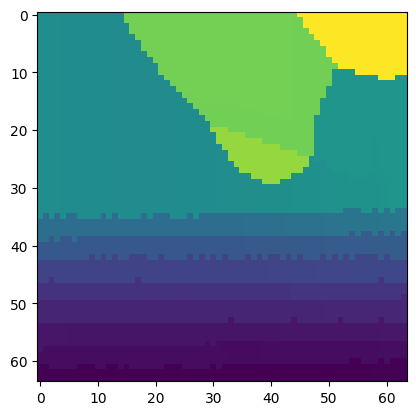

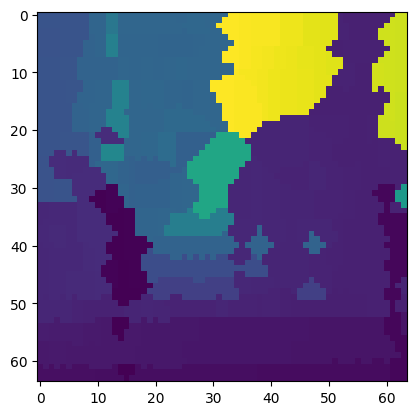

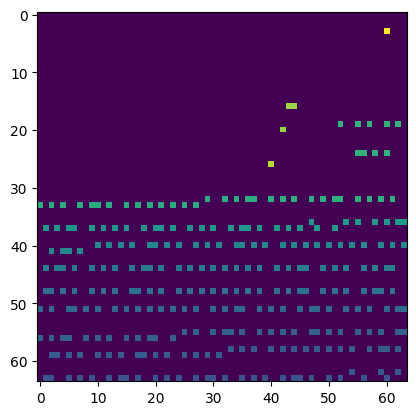

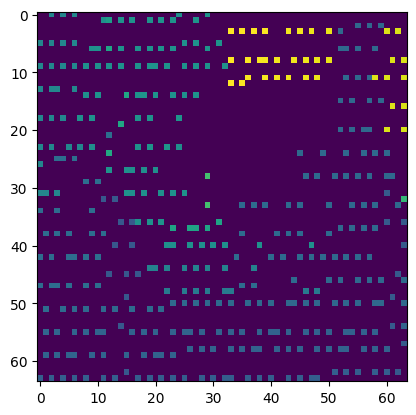

In [13]:
for img in eval_batch["input_img"]:
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()
for img in eval_batch["cond_image"]:
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()

In [59]:
from PIL import Image
import requests
import numpy as np

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
rgb = torch.from_numpy(np.array(image))

rgb_pixel_values = ds.ds.extract_img_features(rgb)
rgb_embed = ds.ds.extractor_model.get_image_features(
    pixel_values=rgb_pixel_values
)
torch.save(rgb_embed, "random_coco_embed.pt")

In [62]:
import numpy as np
np.corrcoef(eval_batch["text_embed"][0], rgb_embed.detach())
# np.corrcoef(eval_batch["text_embed"][0], eval_batch["text_embed"][1])

array([[1.        , 0.56660424],
       [0.56660424, 1.        ]])

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

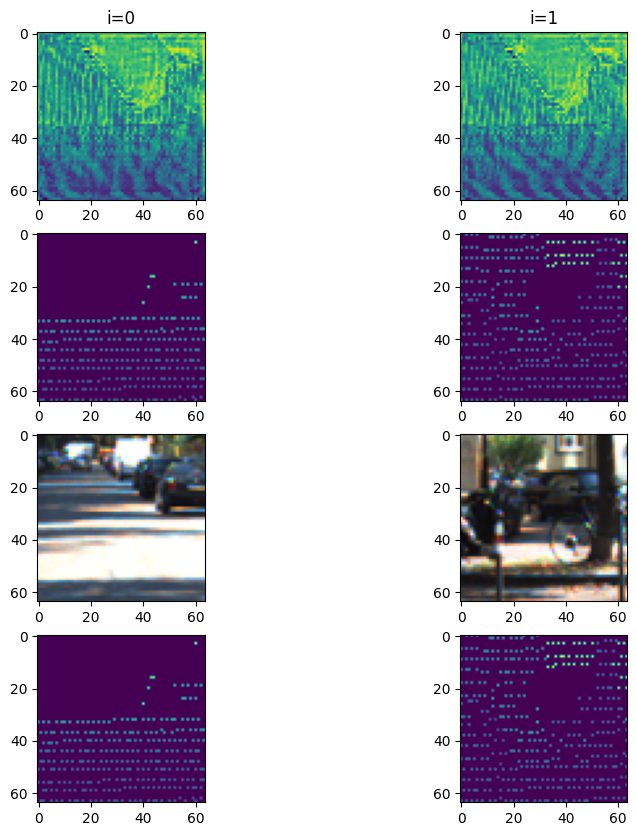

In [66]:
samples = trainer.sample(
    text_embeds=eval_batch["text_embed"],
    cond_images=eval_batch["cond_image"],
    # text_embeds=eval_batch["text_embed"][0].unsqueeze(0),
    # cond_images=eval_batch["cond_image"][0].unsqueeze(0),
    cond_scale=1000,
    # cond_scale=cfg.cond_scale,
    batch_size=cfg.batch_size,
    stop_at_unet_number=None,
    return_all_unet_outputs=True,
)
unet_idx=0
fix, axs = plt.subplots(4, len(samples[unet_idx]) if len(samples[unet_idx]) > 1 else 2, figsize=(10, 10))
for i in range(len(samples[unet_idx])):
    axs[0,i].imshow(samples[unet_idx][i].permute(1, 2, 0).cpu().numpy())
    axs[0,i].set_title(f"{i=}")
    axs[1,i].imshow(eval_batch["cond_image"][i].permute(1, 2, 0).cpu().numpy())
    axs[2,i].imshow(eval_batch["rgb"][i].permute(1, 2, 0).cpu().numpy())
    axs[3,i].imshow(eval_batch["sdm"][i].permute(1, 2, 0).cpu().numpy())
plt.show()

In [46]:
eval_batch['text_embed']

tensor([[[-0.1960, -0.2531, -0.5287,  ...,  0.8040, -0.3824, -0.2557]],

        [[-0.1983, -0.2562, -0.4372,  ...,  0.7565, -0.3465, -0.2152]]])

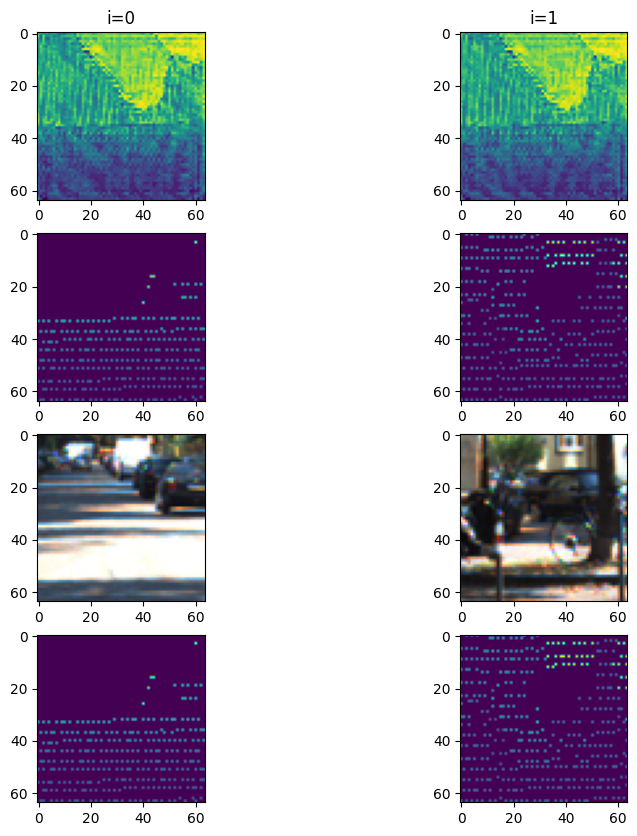

In [39]:
fix, axs = plt.subplots(4, len(samples[0]) if len(samples[0]) > 1 else 2, figsize=(10, 10))
for i in range(len(samples[0])):
    axs[0,i].imshow(samples[0][i].permute(1, 2, 0).cpu().numpy())
    axs[0,i].set_title(f"{i=}")
    axs[1,i].imshow(eval_batch["cond_image"][i].permute(1, 2, 0).cpu().numpy())
    axs[2,i].imshow(eval_batch["rgb"][i].permute(1, 2, 0).cpu().numpy())
    axs[3,i].imshow(eval_batch["sdm"][i].permute(1, 2, 0).cpu().numpy())
plt.show()

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

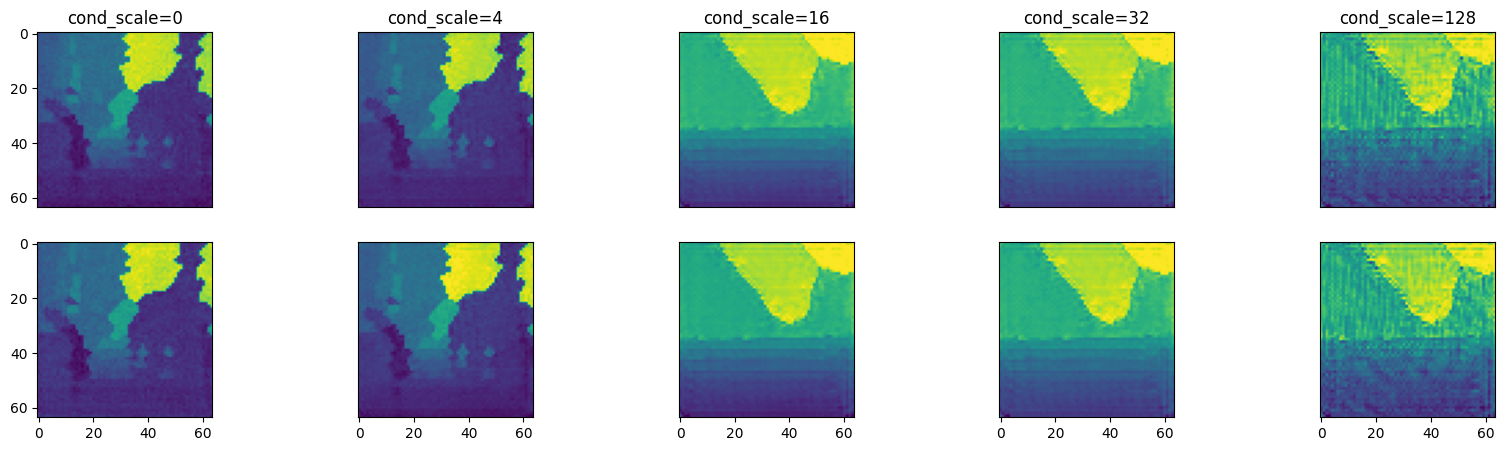

In [22]:
def compare_diff_cond_scales(trainer):
    cond_scales = list([0,4,16,32,128])
    fix, axs = plt.subplots(cfg.batch_size, len(cond_scales), figsize=(20, 5))
    for i, cond_scale in enumerate(cond_scales):
        samples = trainer.sample(
            text_embeds=eval_batch["text_embed"],
            cond_images=eval_batch["cond_image"],
            cond_scale=cond_scale,
            batch_size=cfg.batch_size,
            stop_at_unet_number=None,
            return_all_unet_outputs=True,
        )
        for sample_idx in range(cfg.batch_size):
            axs[sample_idx, i].imshow(samples[0][sample_idx].permute(1, 2, 0).cpu().numpy())
            axs[0, i].set_title(f"{cond_scale=}")
            if sample_idx==0:
                axs[sample_idx, i].set_xticks([])
            # if sample_idx!=0:
            #     axs[sample_idx, i].set_yticklabels([])
            #     axs[sample_idx, i].set_yticks([])
            #     axs[sample_idx, i].set_xticklabels([])
            if i!=0:
                axs[sample_idx, i].set_yticklabels([])
                axs[sample_idx, i].set_yticks([])
        # break
    plt.show()
compare_diff_cond_scales(trainer)